## Importing Required Librarys

In [1]:
from os import listdir
from pickle import dump, load
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from tqdm import tqdm

## Extracting Features

In [2]:
def extract_features(directory):
    # VGG16 class model
    model = VGG16()

    # Removing The Output Layer
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

    # Summarizing
    print(model.summary())

    # Extracting Features From Each Photo
    features = {}
    for name in tqdm(listdir(directory)):
        try:
            # Loading Images
            file_name = directory + "/" + name
            image = load_img(file_name, target_size=(224, 224))

            # Converting Images To Numpy Array
            image_arr = img_to_array(image)

            # Reshape the array for the model
            image_arr = image_arr.reshape((1, image_arr.shape[0], image_arr.shape[1], image_arr.shape[2]))

            # Preparing Image_arr for VGG model
            image_processed = preprocess_input(image_arr)

            # Get features
            feature = model.predict(image_processed, verbose=0)

            # Extracting the image id
            feature_id = name.split(".")[0]

            # Adding The feature to features dictionary
            features[feature_id] = feature
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")

    # Return the features
    return features

In [3]:
directory = "images"
features = extract_features(directory)
print(len(features))

553467096/553467096 [==============================] - 100s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

100%|██████████████████████████████████████████████████████████████████████████████| 2046/2046 [46:26<00:00,  1.36s/it]

2046


## Saving The Extracted Feature File

In [4]:
with open("features.pkl", "wb") as file:
    dump(features, file)

## Convert Image Description To Vocabulary

In [5]:
import string
def load_doc(file_name):
  file = open(file_name, "r")
  text = file.read()
  file.close()
  return text

# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split(",")
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:-1]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# cleaning punctuations from descriptions
def clean_descriptions(description):
  # prepare translation table for removing punctuations
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in description.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      # tokenize
      desc = desc.split()
      # converting into lower case for consistancy
      desc = [word.lower() for word in desc]
      # removing 1 chr words: like 'a', 's'
      desc = [word for word in desc if len(word)>1]
      # remove punctuation from each tokens
      desc= [word.translate(table) for word in desc]
      # remove tokens with number in there
      desc = [word for word in desc if word.isalpha()]
      # also removing '"' from thw words
      desc = [word[1:] if '"' in word else word for word in desc]
      # store as string
      desc_list[i] = ' '.join(desc)


# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [6]:
# filename = 'drive/MyDrive/Image_Captioning/image_captions.csv'
filename = "image_captions.csv"

# load descriptions
doc = load_doc(filename)

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

# clean descriptions
clean_descriptions(descriptions)

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 2046 
Vocabulary Size: 2730


## Load prepared Images and Descriptions

In [7]:
from pickle import load

# Reading the description
def load_doc(filename):
  # opening the file as read only
  file = open(filename, "r")
  # read all text
  doc = file.read()
  # clsing the file
  file.close()
  # returning the readed text
  return doc

# loading the predefined list of photo's identifiers
def load_set(filename):
  # loading the doc file
  doc = load_doc(filename)
  # creating an empty list of identifiers
  dataset = list()
  # process line by line
  for line in doc.split("\n"):
    # skip empty lines
    if len(line) < 1:
      continue
    # spliting the line by space
    line = line.split()
    # get the image identifire
    identifire = line[0]
    dataset.append(identifire)
  # Returning the set of identifires
  return set(dataset)

# load clean description into memory
def load_clean_description(filename, dataset):
  # load document
  doc = load_doc(filename)
  description = {}

  for line in doc.split("\n"):
    # split line by white space
    line = line.split()
    # split id form description
    img_id, img_desc = line[0], line[1:]
    # skip images not in the set
    if img_id in dataset:
      if img_id not in description:
        # vreating a list for the description
        description[img_id] = list()
      # wrap description in tokens
      for token in img_desc:
        desc = '<startseq> ' + token + ' <endseq>'
        # store it
        description[img_id].append(desc)

  return description

# load photo features
def load_photo_features(filename, dataset):
    # Open the file in read mode
    with open(filename, 'rb') as file:
        # load all features
        all_feature = load(file)

    # filter features
    features = {k: all_feature[k] for k in dataset}

    return features

In [8]:
filename = "descriptions.txt"
train = load_set(filename)
print(sorted(train))
train_desc = load_clean_description(filename, train)
print(train_desc)
train_features = load_photo_features("features.pkl", train)
print(train_features['0'])

['0', '1002', '1005', '1008', '1011', '1014', '1017', '102', '1020', '1023', '1026', '1029', '1032', '1035', '1038', '1041', '1044', '1047', '105', '1050', '1053', '1056', '1059', '1062', '1065', '1068', '1071', '1074', '1077', '108', '1080', '1083', '1086', '1089', '1092', '1095', '1098', '1101', '1104', '1107', '111', '1110', '1113', '1116', '1119', '1122', '1125', '1128', '1131', '1134', '1137', '114', '1140', '1143', '1146', '1149', '1152', '1155', '1158', '1161', '1164', '1167', '117', '1170', '1173', '1176', '1179', '1182', '1185', '1188', '1191', '1194', '1197', '12', '120', '1200', '1203', '1206', '1209', '1212', '1215', '1218', '1221', '1224', '1227', '123', '1230', '1233', '1236', '1239', '1242', '1245', '1248', '1251', '1254', '1257', '126', '1260', '1263', '1266', '1269', '1272', '1275', '1278', '1281', '1284', '1287', '129', '1290', '1293', '1296', '1299', '1302', '1305', '1308', '1311', '1314', '1317', '132', '1320', '1323', '1326', '1329', '1332', '1335', '1338', '1341',

## Description Tokenization & Numeric Mapping

In [102]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# covert a dictionary into clean descriptions of a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(k) for k in descriptions[key]]
  return all_desc

# fit a tokenizer given caption description
def create_tokenizer(descriptions):
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

# Calculate the length of the descriptions with most word
def max_length(descriptions):
  line = to_lines(descriptions)
  return max(len(d.split()) for d in line)

# Creating Sequences of images, input sequneces and output words for an image
# For Example:
# X1          X2                                        Y
# img         <startsqe>                                the
# img         <startsqe> the                            man
# img         <startsqe> the man                        standing
# img         <startsqe> the man stanging <endseq>
def create_sequences(tokenizer, max_length, desc_list, photos):
  # Initialize lists to store the data
  X1, X2, Y = [], [], []

  # Loop through each image description and its corresponding photo
  for key, desc_list in descriptions.items():
      photo = photos[key][0]
      for desc in desc_list:
          seq = tokenizer.texts_to_sequences([desc])[0]
          for i in range(1, len(seq)):
              in_seq, out_seq = seq[:i], seq[i]
              in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
              out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
              X1.append(photo)
              X2.append(in_seq)
              Y.append(out_seq)
  return np.array(X1), np.array(X2), np.array(Y)

In [120]:
all_desc = to_lines(train_desc)
print(all_desc)
tokenizer = create_tokenizer(train_desc)
print(tokenizer) # from keras.preprocessing.text import Tokenizer
# Save the tokenizer to a file
with open("tokenizer.pkl", "wb") as tokenizer_file:
    dump(tokenizer, tokenizer_file)

# get vocanualry size
vocab_size = len(tokenizer.word_index) + 1
print("vocabualry size = %d" % vocab_size)

# max_length descriptions with most word
max_len = max_length(descriptions)
print(max_len)

# Sequneces
X1, X2, Y = create_sequences(tokenizer, max_len, all_desc, train_features)

['<startseq> appetizer <endseq>', '<startseq> closeup <endseq>', '<startseq> snack <endseq>', '<startseq> food <endseq>', '<startseq> maasdam <endseq>', '<startseq> grape <endseq>', '<startseq> fruit <endseq>', '<startseq> boiled <endseq>', '<startseq> bun <endseq>', '<startseq> food <endseq>', '<startseq> cheese <endseq>', '<startseq> male <endseq>', '<startseq> teenager <endseq>', '<startseq> black <endseq>', '<startseq> color <endseq>', '<startseq> ethnic <endseq>', '<startseq> child <endseq>', '<startseq> adult <endseq>', '<startseq> drink <endseq>', '<startseq> breakfast <endseq>', '<startseq> food <endseq>', '<startseq> juice <endseq>', '<startseq> objectsequipment <endseq>', '<startseq> fruit <endseq>', '<startseq> freshness <endseq>', '<startseq> morning <endseq>', '<startseq> onion <endseq>', '<startseq> picnic <endseq>', '<startseq> meat <endseq>', '<startseq> lunch <endseq>', '<startseq> kebab <endseq>', '<startseq> pork <endseq>', '<startseq> preparation <endseq>', '<starts

## Model building

In [104]:
from keras import Input
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import add

# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    # summarize model
    print(model.summary())
    return model

In [105]:
# load training data set
filename = "descriptions.txt"
train = load_set(filename)
print("Train Dataset: %d" % len(train))

# descriptions
train_desc = load_clean_description(filename, train)
print("Train Descriptions: %d" % len(train_desc))

# photo features
train_features = load_photo_features("features.pkl", train)
print("Train photo features = %d" % len(train_features))

# prepare Tokenizer
tokenizer = create_tokenizer(train_desc)
vocab_size = len(tokenizer.word_index)+1
print("Vocab length = %d" % vocab_size)

# determining the max sequence length
max_len = max_length(train_desc)
print("Max Length = %d" % max_len)

Train Dataset: 2046
Train Descriptions: 2046
Train photo features = 2046
Vocab length = 2733
Max Length = 3


In [131]:
# Define the model
model = define_model(vocab_size, max_len)
X1, X2, Y = create_sequences(tokenizer, max_len, all_desc, train_features)

# Train The Model
model_hist = model.fit([X1, X2], Y, epochs=40, verbose=1)

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_86 (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 input_85 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                                  
 embedding_35 (Embedding)       (None, 8, 256)       699648      ['input_86[0][0]']               
                                                                                                  
 dropout_70 (Dropout)           (None, 1000)         0           ['input_85[0][0]']               
                                                                                           

## Saving The Model And Model History

In [133]:
# Saving the model
with open("model.pkl", "wb") as f:
  dump(model, f)

In [134]:
# Recording History In Json Formate
import json
with open("training_hist.json", "w") as f:
    json.dump(model_hist.history, f)

## Predcitions

In [142]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pickle import load
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Model

# Function to preprocess a new image
def preprocess_image(image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

def extract_feature_for_image(image_path):
    # Load the VGG16 model
    model = VGG16()

    # Remove the output layer to get features from the second last layer
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features from the image
    features = model.predict(image, verbose=0)

    return features


# Function to generate captions for a new image
def generate_caption(model, tokenizer, max_length, photo_features):
    # Start with the initial token
    in_text = '<startseq>'
    # Iterate over the sequence length
    for _ in range(max_length):
        # Encode the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word
        yhat = model.predict([photo_features, sequence], verbose=0)
        # Convert the model's output to a word
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        # Break if we reach the end of the sequence
        if word is None or word == '<endseq>':
            break
        # Append the predicted word to the input sequence
        in_text += ' ' + word
    return in_text + ' <endseq>'

# Function to map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Load the pre-trained image captioning model
with open('model.pkl', "rb") as f:
  model = load(f)

# Load the tokenizer used during training
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = load(tokenizer_file)

# Load the photo features for the new image (you need to extract features for the new image)
new_image_path = 'images/372.jpg'
image_features = extract_feature_for_image(new_image_path)


# Set the maximum length for generated captions
max_length = 8  # Set this to the same value you used during training

# Generate a caption for the new image
caption = generate_caption(model, tokenizer, max_length, image_features)

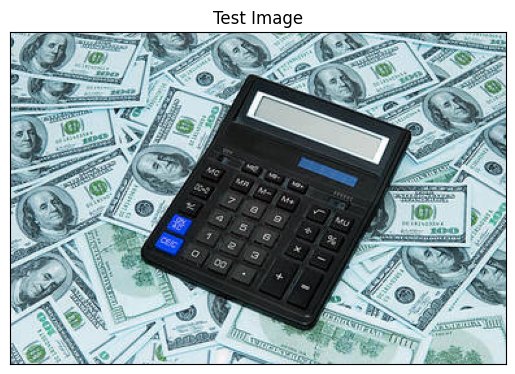

In [141]:
import matplotlib.pyplot as plt
import cv2
img_path = "images/372.jpg"
img = cv2.imread(img_path)
plt.imshow(img)
plt.title("Test Image")
plt.xticks([])
plt.yticks([])
plt.show()

In [143]:
# Print the generated caption
print('Generated Caption:', caption)

Generated Caption: <startseq> currency calculator dividends interest rate gambling businessmans debt <endseq>


## Visualising The Accuracy

In [151]:
with open('training_hist.json', 'r') as history:
    model_hist = json.load(history)

print(model_hist)

{'loss': [7.076819896697998, 6.380422592163086, 5.826691627502441, 5.377475261688232, 4.9714508056640625, 4.587459564208984, 4.2341179847717285, 3.867649793624878, 3.5106430053710938, 3.1547341346740723, 2.8013126850128174, 2.4444172382354736, 2.127826452255249, 1.870475172996521, 1.6278268098831177, 1.4251114130020142, 1.2609831094741821, 1.1217178106307983, 1.0119961500167847, 0.9003531336784363, 0.8350330591201782, 0.7552239298820496, 0.6990281939506531, 0.6401808857917786, 0.581085741519928, 0.5522576570510864, 0.5256186723709106, 0.4960598349571228, 0.47379958629608154, 0.4444294273853302, 0.4234955608844757, 0.41851872205734253, 0.39418452978134155, 0.38140130043029785, 0.3643540143966675, 0.3544434607028961, 0.34015047550201416, 0.32431796193122864, 0.3212754726409912, 0.30474546551704407], 'accuracy': [0.029102729633450508, 0.055030614137649536, 0.0864010900259018, 0.1136140301823616, 0.1362914741039276, 0.1629752814769745, 0.19298510253429413, 0.22307053208351135, 0.2670647799

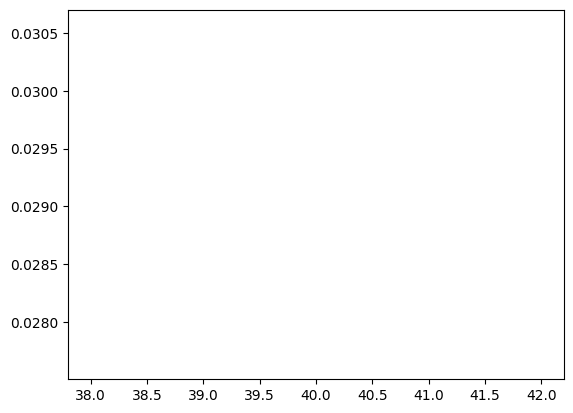

In [154]:
epochs = 40
plt.plot(epochs, model_hist['accuracy'][0], color="red")